In [57]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import optuna

In [3]:
# считывем данные из файла
data = pd.read_csv('data/train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


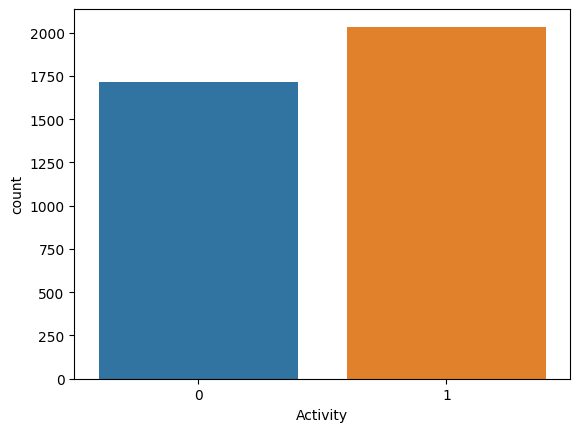

In [5]:
# Проверяем данные на сбалансированность классов
sns.countplot(data=data, x='Activity');

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: 
- логистическую регрессию
- случайный лес. 

Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [8]:
# Создаем матрицу наблюдений Х и вектор ответов у
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [9]:
# Разделяем выборку на тренировочную и тестовую в соотношении 80/20. 
# Т.к. в данных есть небольшое преобладание класса 1, то для сохранения соотношений целевого признака используем параметр stratify. 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

# <center> Логистическая регрессия
Сначала обучим модель логистической регрессии и подберем для нее гиперпараметры с помощью базовых и продвинутых методом оптимизации.

Зафиксируем метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [10]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


### **GridSearchCV**

In [11]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

CPU times: user 3.44 s, sys: 918 ms, total: 4.36 s
Wall time: 4min 52s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Использование GridSearchCV позволило увеличить нашу метрику F1 с 0.78 до 0.79**

In [14]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.76


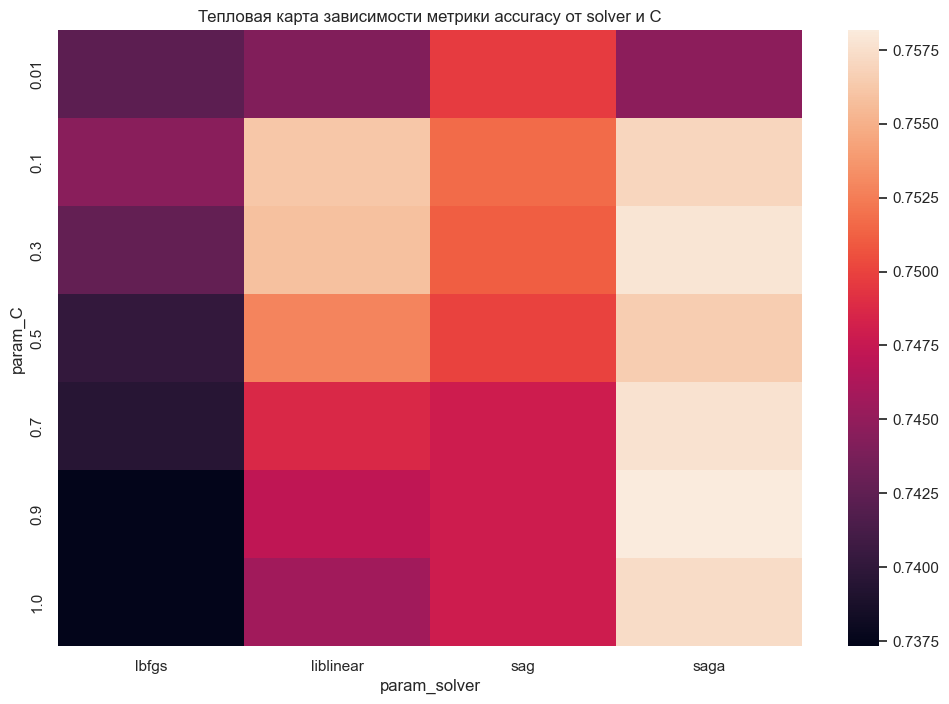

In [19]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Видим, что слабая регуляризация С = 0,01 отрицательно влияет на метрику, поэтому есть смысл брать значения больше 0,5 и алгоритм оптимизации saga работает намного лучше.

### **RandomizedSearchCV**

In [25]:
param_distributions = {
              'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'lbfgs', 'saga', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))
               }          
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

CPU times: user 3.82 s, sys: 245 ms, total: 4.06 s
Wall time: 58.5 s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.12}


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Использование RandomizedSearchCV также позволило увеличить нашу метрику F1 с 0.78 до 0.79**

### **Hyperopt**

In [77]:
# зададим пространство поиска гиперпараметров
space={'penalty': hp.choice('penalty', ['l1', 'l2']),
       'solver' : hp.choice('solver', ['liblinear', 'saga']),
       'C': hp.uniform('C', low=0.01, high=1)
      }

In [78]:
# зафксируем random_state
random_state = 42
def hyperopt_Log_reg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
             'C': params['C']
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return {'loss': -score, 'params': params, 'status': STATUS_OK}

In [79]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_Log_reg, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(trials.best_trial['result']['params']))

  4%|▍         | 2/50 [00:12<05:46,  7.22s/trial, best loss: -0.8760330578512396]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  8%|▊         | 4/50 [00:23<04:57,  6.47s/trial, best loss: -0.8760330578512396]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 12%|█▏        | 6/50 [00:30<03:52,  5.28s/trial, best loss: -0.8760330578512396]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 14%|█▍        | 7/50 [00:37<04:10,  5.83s/trial, best loss: -0.8760330578512396]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|██        | 10/50 [00:51<03:46,  5.67s/trial, best loss: -0.8807339449541284]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 24%|██▍       | 12/50 [00:58<03:08,  4.95s/trial, best loss: -0.8807339449541284]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 28%|██▊       | 14/50 [01:11<03:34,  5.95s/trial, best loss: -0.8807339449541284]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 15/50 [01:22<04:27,  7.64s/trial, best loss: -0.8807339449541284]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 34%|███▍      | 17/50 [01:31<03:24,  6.19s/trial, best loss: -0.8850855745721271]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 36%|███▌      | 18/50 [01:40<03:54,  7.33s/trial, best loss: -0.8850855745721271]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 38%|███▊      | 19/50 [01:52<04:25,  8.56s/trial, best loss: -0.8850855745721271]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 86%|████████▌ | 43/50 [02:16<00:18,  2.58s/trial, best loss: -0.8856968215158926]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 92%|█████████▏| 46/50 [02:25<00:13,  3.43s/trial, best loss: -0.8856968215158926]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 96%|█████████▌| 48/50 [02:33<00:07,  3.92s/trial, best loss: -0.8856968215158926]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 50/50 [02:41<00:00,  3.24s/trial, best loss: -0.8856968215158926]
Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9985710176440787}
CPU times: user 2min 34s, sys: 3.25 s, total: 2min 38s
Wall time: 2min 41s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



In [80]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=trials.best_trial['result']['params']['penalty'],
    solver=trials.best_trial['result']['params']['solver'],
    C=trials.best_trial['result']['params']['C']
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.89
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


**Использование Hyperopt не улучшило нашу метрику, F1 = 0.78**

### **Optuna**

In [83]:
def optuna_log_reg(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', low=0.01, high=1)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [84]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_log_reg, n_trials=50)

[I 2024-05-10 20:44:44,951] A new study created in memory with name: LogisticRegression
[I 2024-05-10 20:44:45,787] Trial 0 finished with value: 0.8148371531966225 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.1887877022256806}. Best is trial 0 with value: 0.8148371531966225.
[I 2024-05-10 20:44:47,124] Trial 1 finished with value: 0.8661369193154035 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.9399811941811593}. Best is trial 1 with value: 0.8661369193154035.
[I 2024-05-10 20:44:47,738] Trial 2 finished with value: 0.8677054689886954 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.3262336846102354}. Best is trial 2 with value: 0.8677054689886954.
[I 2024-05-10 20:44:48,339] Trial 3 finished with value: 0.8674404398289554 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.30615749050186275}. Best is trial 2 with value: 0.8677054689886954.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklea

CPU times: user 1min 28s, sys: 2.33 s, total: 1min 31s
Wall time: 1min 34s


In [85]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9986103345407616}
f1_score на обучающем наборе: 0.89


In [86]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


**Использование Optuna также не улучшило нашу метрику, F1 = 0.78**

# <center> Случайный лес
Теперь обучим модель случайного леса и подберем для нее гиперпараметры с помощью базовых и продвинутых методом оптимизации.

Зафиксируем метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [87]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.81


### **GridSearchCV**

In [89]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: user 3.43 s, sys: 541 ms, total: 3.97 s
Wall time: 1min 44s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


**Использование GridSearchCV позволило увеличить нашу метрику F1 с 0.81 до 0.82**

### **RandomizedSearchCV**

In [90]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 4.3 s, sys: 605 ms, total: 4.9 s
Wall time: 3min 26s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': 20}


**Использование GridSearchCV также позволило увеличить нашу метрику F1 с 0.81 до 0.82**

### **Hyperopt**

In [92]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 80, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [93]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [94]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [02:43<00:00,  3.27s/trial, best loss: -0.992651561543172] 
Наилучшие значения гиперпараметров {'max_depth': 25.0, 'min_samples_leaf': 2.0, 'n_estimators': 174.0}
CPU times: user 2min 33s, sys: 3.82 s, total: 2min 36s
Wall time: 2min 43s


In [95]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


**Использование Hyperopt также позволило увеличить нашу метрику F1 с 0.81 до 0.82**

### **Optuna**

In [96]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 80, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [97]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2024-05-10 21:49:45,538] A new study created in memory with name: RandomForestClassifier
/var/folders/jr/y6j710014w98cjhsh00zh_gw0000gn/T/ipykernel_11842/1781554741.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 80, 300, 10)
/var/folders/jr/y6j710014w98cjhsh00zh_gw0000gn/T/ipykernel_11842/1781554741.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
/var/folders/jr/y6j710014w98cjhsh00zh_gw0000gn/T/ipykernel_11842/1781554741.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 7, 1)
[I 2024-05-10 21:49:49,407] Trial 0 finished with value: 0.9779546846295162 and parameters: {'n_estimator

CPU times: user 4min 15s, sys: 6.32 s, total: 4min 22s
Wall time: 4min 57s


In [98]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [99]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


**И наконец использование Optuna также позволило увеличить нашу метрику F1 с 0.81 до 0.82**